In [13]:
from scipy.integrate import quad

import TMQGP as tm
from numpy import *

import QuarkTM

import matplotlib
matplotlib.style.use('publication23')

mQ = 0.6


qrange = linspace(0, 5, 51)
erange = linspace(-5, 5, 201)

pt = QuarkTM.Particle(mQ, qrange, erange, eps=5e-2)
T = 0.16
ch = QuarkTM.Channel(pt, pt, T, G=8, screen=0, ds=4, da=1, Fa=1)

import tqdm

from scipy.optimize import minimize

# General setup 

## Getting the T-matrix

In [14]:
ImS_K_Arr = array([[-5e-2 for e in erange] for q in qrange]).transpose()

ReS = array([[0. for e in erange] for q in qrange]).transpose()

eArr = array([erange for q in qrange]).transpose()

omArr = array([pt.om0(qrange) for e in erange])

delta = 1

while delta > 1e-3:
    
    # G = 1 / (eArr - omArr - (ReS + 1j*ImS))
    
    G2 = (1 - ch.nf(omArr, T) - ch.nf(omArr, T))/(eArr - 2*omArr - 2*(1j*ImS_K_Arr))

    iImG2 = tm.InterDenom2D(qrange, erange, ascontiguousarray(nan_to_num(real(1/G2), posinf=0, neginf=0)), 
                            ascontiguousarray(nan_to_num(imag(1/G2), posinf=0, neginf=0)), 'imag')
    iReG2 = tm.InterDenom2D(qrange, erange, ascontiguousarray(nan_to_num(real(1/G2), posinf=0, neginf=0)), 
                            ascontiguousarray(nan_to_num(imag(1/G2), posinf=0, neginf=0)), 'real')

    X = array([
        tm.x_solve(e, 0, 0, T, ch.iVS[0], ch.iOm, iReG2, iImG2, 5, 1, 1)
    for e in erange])

    X[erange < 0] = real(X[erange < 0])
        
    TM = array([-4*pi*ch.v(q)**2 / (1 - X) for q in qrange]).transpose()
    
    iImTM = tm.InterDenom2D(qrange, erange, ascontiguousarray(nan_to_num(real(1/TM), posinf=0, neginf=0)), 
                        ascontiguousarray(nan_to_num(imag(1/TM), posinf=0, neginf=0)), 'imag')

    iReTM = tm.InterDenom2D(qrange, erange, ascontiguousarray(nan_to_num(real(1/TM), posinf=0, neginf=0)), 
                            ascontiguousarray(nan_to_num(imag(1/TM), posinf=0, neginf=0)), 'real')

    iEps = tm.Interpolator(qrange, ascontiguousarray(omArr[0, :]), 'cubic')
    
    ImS_tab = array([[tm.SigmaQP(e, q, T, iImTM, iImG2, iEps, iEps, 0, 0, 5) for e in erange]
                for q in tqdm.notebook.tqdm(qrange)])

    ImS_tab = ch.Nf * ch.ds * ch.da / ch.p_i.d * ImS_tab.transpose()

    ReS_tab = []
    for im in ImS_tab.transpose():
        iIm = tm.Interpolator(erange, ascontiguousarray(im), 'cubic')
        re = [tm.ReSigmaKK(e, iIm) for e in erange]
        ReS_tab += [re]
    
    ReS_tab = array(ReS_tab).transpose()

    iReS = tm.Interpolator2D(qrange, erange, ascontiguousarray(ReS_tab))
    def eq(x, k):
        return x - sqrt(k**2 + mQ**2) - iReS(k, x)

    omK = []
    init = mQ
    for k in qrange:
        sol = minimize(lambda z: eq(z[0], k)**2, mQ, bounds=[[0.9*init, 1.1*init]])
        omK += [float(sol.x)]
        # print(sol.status)
        init = sol.x

    iImS = tm.Interpolator2D(qrange, erange, ascontiguousarray(ImS_tab))

    ImS_K = []
    ReS_K = []
    
    for k, om in zip(qrange, omK):
        ImS_K += [iImS(k, float(om))]
        ReS_K += [iReS(k, float(om))]

    ImS_K_Arr = array([ImS_K for e in erange])
    omArr_prev = omArr
    omArr = array([omK for e in erange])
    ImS = ImS_tab
    ReS = ReS_tab

    delta = np.max(np.abs(omArr_prev - omArr))
    print(delta)

  0%|          | 0/51 [00:00<?, ?it/s]

0.11772374697017818


/tmp/ipykernel_120494/3315644380.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  omK += [float(sol.x)]


  0%|          | 0/51 [00:00<?, ?it/s]

0.05149045410218256


  0%|          | 0/51 [00:00<?, ?it/s]

0.03201717673063287


  0%|          | 0/51 [00:00<?, ?it/s]

0.020565894470723323


  0%|          | 0/51 [00:00<?, ?it/s]

0.012670917666404602


  0%|          | 0/51 [00:00<?, ?it/s]

0.007977928765496856


  0%|          | 0/51 [00:00<?, ?it/s]

0.0049257524050023704


  0%|          | 0/51 [00:00<?, ?it/s]

0.0031335392170512844


  0%|          | 0/51 [00:00<?, ?it/s]

0.001979568962978684


  0%|          | 0/51 [00:00<?, ?it/s]

0.0012629972595924466


  0%|          | 0/51 [00:00<?, ?it/s]

0.0008120068032423378


(0.0, 1.0)

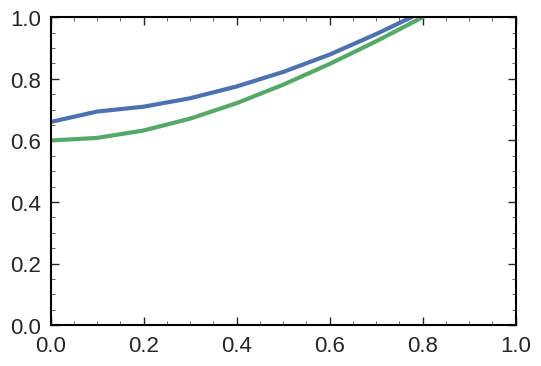

In [15]:
plt.plot(qrange, omArr[0, :])
plt.plot(qrange, sqrt(mQ**2 + qrange**2))

plt.xlim(0, 1)
plt.ylim(0, 1)

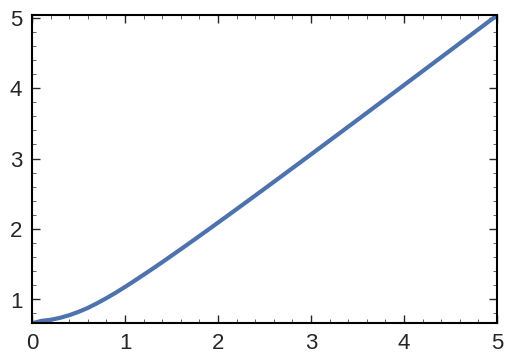

In [16]:
plt.plot(qrange, omArr[0, :])

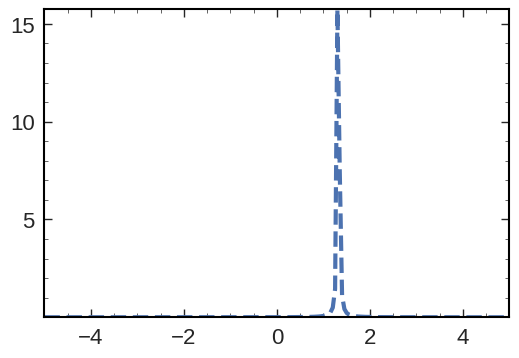

In [17]:
# plt.plot(erange, [-iImG2(0., e) for e in erange])
# plt.plot(erange, [-ch.iImG2(0., e) for e in erange], ls=':')
plt.plot(erange, -imag(G2[:, 0]), ls='--')
# plt.semilogy()

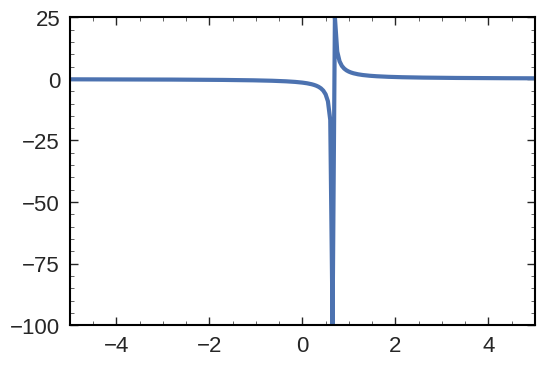

In [18]:
plt.plot(erange, 1/(erange - omArr[:, 0] ))

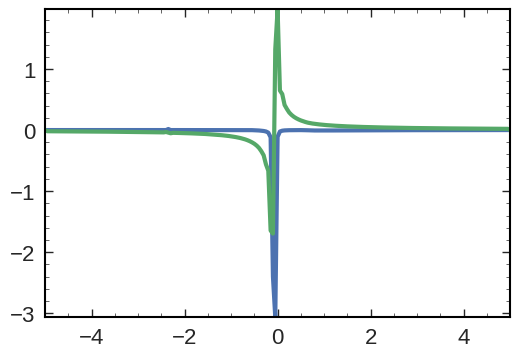

In [20]:
plt.plot(erange, ImS[:, 0])
plt.plot(erange, ReS[:, 0])

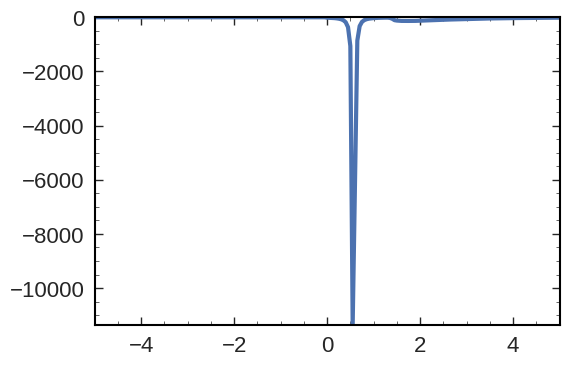

In [21]:
plt.plot(erange, imag(TM[:, 0]))

In [22]:
iImG2(0.5, 0.7), ch.iImG2(0.5, 0.7)

(-0.006563148184298808, -0.0547038575092362)

In [23]:
X = array([
    tm.x_solve(e, 0, 0, T, ch.iVS[0], ch.iOm, iReG2, iImG2, 5, 1, 1)
    for e in erange])

In [60]:
TM = array([-4*pi*ch.v(q)**2 / (1 - X) for q in qrange]).transpose()

# Calculating $\Sigma$

In [132]:
iImTM = tm.InterDenom2D(qrange, erange, ascontiguousarray(nan_to_num(real(1/TM), posinf=0, neginf=0)), 
                        ascontiguousarray(nan_to_num(imag(1/TM), posinf=0, neginf=0)), 'imag')

iReTM = tm.InterDenom2D(qrange, erange, ascontiguousarray(nan_to_num(real(1/TM), posinf=0, neginf=0)), 
                        ascontiguousarray(nan_to_num(imag(1/TM), posinf=0, neginf=0)), 'real')